In [2]:
import torch
import numpy as np
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

train_transforms = T.Compose([
    T.RandomResizedCrop(scale=(0.7, 1.0), size=(150,150)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])
eval_transforms = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])


# Create our data set splits and transform to tensors
train_valid_data = ImageFolder('Images/seg_train/', transform = train_transforms)
test_data = ImageFolder('Images/seg_test/', transform = eval_transforms)
print(train_valid_data.class_to_idx)

dataset_subset = torch.utils.data.Subset(train_valid_data, np.random.choice(len(train_valid_data), 13000, replace=False))
train_data = 10000
valid_data = 3000
train_data, valid_data = random_split(dataset_subset, [train_data, valid_data])

# Check our data set sizes
print("Train: {} examples".format(len(train_data)))
print("Valid: {} examples".format(len(valid_data)))
print("Test: {} examples".format(len(test_data)))

# Wrap in DataLoader objects with batch size and shuffling preference
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=len(valid_data), shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)

# Check number of batches
print("Train: {} batches".format(len(train_loader)))
print("Valid: {} batches".format(len(valid_loader))) # Should be 1
print("Test: {} batches".format(len(test_loader))) # Should be 1

print(train_valid_data[0][0].shape)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Train: 10000 examples
Valid: 3000 examples
Test: 2980 examples
Train: 157 batches
Valid: 1 batches
Test: 1 batches
torch.Size([3, 150, 150])


In [3]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_layer_1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv_layer_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv_layer_3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv_layer_4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.fc_layer_1 = torch.nn.Sequential(
            torch.nn.Linear(10368, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU()
        )
        self.fc_layer_2 = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ReLU()
        )
        self.fc_layer_3 = torch.nn.Sequential(
            torch.nn.Linear(64, 32),
            torch.nn.Dropout(),
            torch.nn.ReLU()
        )
        self.fc_layer_4 = torch.nn.Linear(32, 6)
        

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc_layer_1(x)
        x = self.fc_layer_2(x)
        x = self.fc_layer_3(x)
        x = self.fc_layer_4(x)
        return x

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {}'.format(device))

# Create an object from the model
model = Model().to(device)

# Set loss function and optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

Using cpu


In [8]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
# Train for 10 epochs
for epoch in range(35):
    ### Training
    # Track epoch loss and accuracy
    epoch_loss, epoch_accuracy = 0, 0
    # Switch model to training (affects batch norm and dropout)
    model.train()
    # Iterate through batches
    for i, (data, label) in enumerate(train_loader):
        # Reset gradients
        optimizer.zero_grad()
        # Move data to the used device
        data = data.to(device)
        label = label.to(device)
        # Forward pass
        output = model(data)
        loss = loss_fn(output, label)
        # Backward pass
        loss.backward()
        # Adjust weights
        optimizer.step()
        # Compute metrics
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    print('Epoch: {}, train accuracy: {:.2f}%, train loss: {:.4f}'.format(epoch+1, epoch_accuracy*100, epoch_loss))
    train_losses.append(epoch_loss.item())
    train_accs.append(epoch_accuracy)
    ### Evaluation
    # Track epoch loss and accuracy
    epoch_valid_accuracy, epoch_valid_loss = 0, 0
    # Switch model to evaluation (affects batch norm and dropout)
    model.eval()
    # Disable gradients
    with torch.no_grad():
        # Iterate through batches
        for data, label in valid_loader:
            # Move data to the used device
            data = data.to(device)
            label = label.to(device)
            # Forward pass
            valid_output = model(data)
            valid_loss = loss_fn(valid_output, label)
            # Compute metrics
            acc = ((valid_output.argmax(dim=1) == label).float().mean())
            epoch_valid_accuracy += acc/len(valid_loader)
            epoch_valid_loss += valid_loss/len(valid_loader) 
    print('Epoch: {}, val accuracy: {:.2f}%, val loss: {:.4f}'.format(epoch+1, epoch_valid_accuracy*100, epoch_valid_loss))
    val_losses.append(epoch_valid_loss.item())
    val_accs.append(epoch_valid_accuracy)

Epoch: 1, train accuracy: 56.90%, train loss: 1.1319
Epoch: 1, val accuracy: 55.50%, val loss: 1.1761
Epoch: 2, train accuracy: 72.06%, train loss: 0.8003
Epoch: 2, val accuracy: 74.63%, val loss: 0.6671
Epoch: 3, train accuracy: 76.88%, train loss: 0.6769
Epoch: 3, val accuracy: 70.60%, val loss: 0.7807
Epoch: 4, train accuracy: 79.20%, train loss: 0.6274
Epoch: 4, val accuracy: 78.33%, val loss: 0.6842
Epoch: 5, train accuracy: 79.95%, train loss: 0.5957
Epoch: 5, val accuracy: 82.33%, val loss: 0.4877
Epoch: 6, train accuracy: 81.40%, train loss: 0.5376
Epoch: 6, val accuracy: 72.77%, val loss: 0.7601
Epoch: 7, train accuracy: 82.57%, train loss: 0.5201
Epoch: 7, val accuracy: 78.67%, val loss: 0.6214
Epoch: 8, train accuracy: 83.41%, train loss: 0.4868
Epoch: 8, val accuracy: 57.00%, val loss: 1.8413
Epoch: 9, train accuracy: 84.71%, train loss: 0.4535
Epoch: 9, val accuracy: 82.57%, val loss: 0.5282
Epoch: 10, train accuracy: 84.38%, train loss: 0.4617
Epoch: 10, val accuracy: 83.

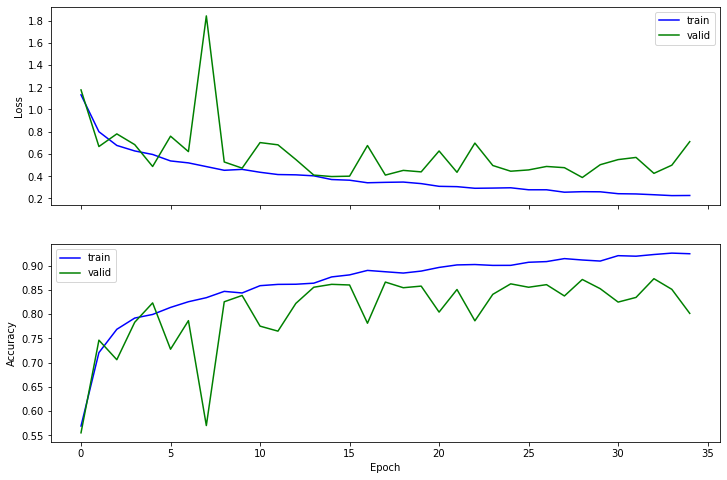

In [9]:
# plot learning curves of accuracy and loss with respect to epochs 

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
ax1.plot(train_losses, color='b', label='train')
ax1.plot(val_losses, color='g', label='valid')
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accs, color='b', label='train')
ax2.plot(val_accs, color='g', label='valid')
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend()

In [10]:
# calculate test accuracy and loss 
test_accuracy, test_loss = 0, 0
with torch.no_grad():
    # Iterate through batches
    for data, label in test_loader:
        # Move data to the used device
        data = data.to(device)
        label = label.to(device)
        # Forward pass
        test_output_i = model(data)
        test_loss_i = loss_fn(test_output_i, label)
        # Compute metrics
        acc = ((test_output_i.argmax(dim=1) == label).float().mean())
        test_accuracy += acc/len(test_loader)
        test_loss += test_loss_i/len(test_loader)

print("Test loss: {:.4f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(test_accuracy*100))

Test loss: 0.6135
Test accuracy: 82.38%


In [12]:
# Specify a path
PATH = "BasicModelState.pt"

# Save
torch.save(model.state_dict(), PATH)